# Análisis Encuesta Origen-Destino -  Limpieza de Datos & Cálculo de Indicadores

## Colombia - Bogotá - 2015

#### Elaborado por Paula Vásquez-Henríquez, Ariel López, Genaro Cuadros, Exequiel Gaete, Alba Vásquez y Juan Correa

In [ ]:
!pip3 uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:30
🔁 Restarting kernel...


In [ ]:
!git clone https://github.com/zorzalerrante/aves.git aves_git

Cloning into 'aves_git'...
remote: Enumerating objects: 851, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 851 (delta 213), reused 452 (delta 194), pack-reused 369
Receiving objects: 100% (851/851), 165.53 MiB | 20.28 MiB/s, done.
Resolving deltas: 100% (336/336), done.
Checking out files: 100% (280/280), done.


In [ ]:
!mamba env update --name base --file aves_git/environment-colab.yml

conda-forge/linux-64     [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 617 KB / ?? (1.99 MB/s)
conda-forge/linux-64     [] (00m:00s) 617 KB / ?? (1.99 MB/s)
conda-forge/noarch       [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 617 KB / ?? (1.99 MB/s)
conda-forge/noarch       [] (00m:00s) 334 KB / ?? (1.08 MB/s)
conda-forge/linux-64     [] (00m:00s) 617 KB / ?? (1.99 MB/s)
conda-forge/noarch       [] (00m:00s) 334 KB / ?? (1.08 MB/s)
pkgs/main/linux-64       [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 617 KB / ?? (1.99 MB/s)
conda-forge/noarch       [] (00m:00s) 334 KB / ?? (1.08 MB/s)
pkgs/main/linux-64       [] (00m:00s) 388 KB / ?? (1.25 MB/s)
conda-forge/linux-64     [] (00m:00s) 617 KB / ?? (1.99 MB/s)
conda-forge/noarch       [] (00m:00s) 334 KB / ?? (1.08 MB/s)
pkgs/main/linux-64       [] (00m:00s) 388 KB / ?? (1.25 MB/s)
pkgs/main/noarch         [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 617 KB / ?? (1.99 MB/s)
conda-forge/noarch       [] (00m:00s) 

In [ ]:
!pip3 install geopandas
!pip3 install haversine
!pip3 install pandasql
!pip3 install openpyxl

     |████████████████████████████████| 1.6 MB 15.0 MB/s 
     |████████████████████████████████| 150 kB 38.0 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=0affda41499b8c7632ff72e8b7e25dc5f3e45f7cb0019eb9dbb4c8d3d5aebfb6
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql
     |████████████████████████████████| 242 kB 12.6 MB/s 


In [ ]:
# Montando datos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import warnings
import haversine as hs
import shapely
from sklearn.preprocessing import normalize
import datetime
import math

In [ ]:
def convert_datatype(df, lista_columnas):
    for column in lista_columnas:
        df[column] = df[column].str.replace(",", ".").astype(float)
    return df

In [ ]:
def imputar_coordenadas_centroide_zat(df, latitud, longitud, zat):
    mask = df[latitud].isnull() | df[longitud].isnull()
    ids_latitud_vacia = df[mask].index
    working_df = pd.merge(df, city_shp[['Zona_Num_N', 'x_coord', 'y_coord']], left_on=zat, right_on='Zona_Num_N', how='left')
    df.loc[ids_latitud_vacia, latitud] = working_df.loc[ids_latitud_vacia, 'y_coord']
    df.loc[ids_latitud_vacia, longitud] = working_df.loc[ids_latitud_vacia, 'x_coord']
    return df

In [ ]:
def mapear_binarias(row, column):
    if row[column] == 'N':
        return 'No'
    elif row[column] == 'S':
        return 'Si'
    else:
        return 'Sin dato'

In [ ]:
def mapear_vacios(row, column):
    if pd.isna(row[column])==True:
        return 'Sin información'
    else:
        return row[column]

In [ ]:
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [ ]:
def normalize_rows(df):
    return df.pipe(lambda x: pd.DataFrame(normalize(df, axis=1, norm='l1'), columns=df.columns, index=df.index))

In [ ]:
def age_cohorts(row, age_column):
    if row[age_column] < 18:
        return '<18'
    elif row[age_column] <=29 and row[age_column] > 18:
        return '18-29'
    elif row[age_column] <=60 and row[age_column] > 29:
        return '30-60'
    elif row[age_column] > 60 and row[age_column] < 100:
        return '>60'
    else:
        return 'No declarado'

### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Bogotá, Colombia del 2015. 
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, de Tiempo de Viajes, y de Distancia de Viajes.

### Importando datos

En esta sección, importamos todos los datos necesarios para el cálculo de indicadores. 
Para el caso de Bogotá 2015, los archivos son de Excel y es necesario hacer una transformación de los datos numéricos.

Cabe destacar que para esta EOD tenemos data a nivel de:
- Viajes
- Etapas
- Personas
- Hogares

In [ ]:
#Seteando carpeta de trabajo
data_path = '/content/drive/MyDrive/Carpeta compartida (clon Teams)/Ciudades/Bogotá/EOD_Bogota/Encuesta de Movilidad 2015'
#data_path = '/Users/pauvasquezh/Dropbox/Proyectos/eod_analysis/Carpeta compartida (clon Teams)/Bogotá/EOD_Bogota/Encuesta de Movilidad 2015'

In [ ]:
# Importando matriz de viajes
data_viajes = pd.read_excel(data_path + '/Tablas Maestras Normalizadas/encuesta 2015 - viajes.xlsx', engine='openpyxl')
data_viajes = convert_datatype(data_viajes, ["LATITUD_ORIGEN", "LATITUD_DESTINO", "LONGITUD_ORIGEN", "LONGITUD_DESTINO", 'PONDERADOR_CALIBRADO_VIAJES', 'FE_TOTAL', 'FACTOR_AJUSTE_TRANSMILENIO', 'PONDERADOR_CALIBRADO'])

In [ ]:
# Importando matriz de personas
data_personas = pd.read_excel(data_path + '/Tablas Maestras Normalizadas/encuesta 2015 - personas.xlsx')
data_personas = convert_datatype(data_personas, ['PONDERADOR_CALIBRADO'])

In [ ]:
# Importando matriz de hogares
data_encuestas = pd.read_excel(data_path + '/Tablas Maestras Normalizadas/encuesta 2015 - encuestas.xlsx')

In [ ]:
# Importando matriz de etapas
data_etapas = pd.read_excel(data_path + '/Tablas Maestras Normalizadas/encuesta 2015 - etapas.xlsx')

In [ ]:
# Importando shapefile de la ciudad
city_shp = gpd.read_file(data_path + "/ZATs/ZATs_2012_MAG.shp")

In [ ]:
# Obteniendo información de proyección del shapefile
city_shp.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Preparación de los datos

#### Viajes

En esta etapa nos enfocaremos en preparar los datos con respecto a viajes.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.

In [ ]:
publico_viaje = ['TPC-SITP','ALIMENTADOR','Transmilenio','INTERMUNICIPAL',]
privado_viaje = ['MOTO', 'AUTO', 'BICICLETA, BICICLETA CON MOTOR', 'PEATON', 'TAXI']
peaton_viaje = ['BICICLETA, BICICLETA CON MOTOR', 'PEATON']
motorizado_viaje = ['TPC-SITP','ALIMENTADOR','Transmilenio','INTERMUNICIPAL', 'TAXI','MOTO', 'AUTO']

In [ ]:
selected_columns = ['ID_ENCUESTA', 'NUMERO_PERSONA', 'NUMERO_VIAJE', 'MOTIVOVIAJE',
       'HORA_INICIO', 'HORA_FIN', 'MEDIO_PREDOMINANTE', 'ZAT_DESTINO', 'ZAT_ORIGEN',
       'LATITUD_ORIGEN', 'LATITUD_DESTINO', 'LONGITUD_ORIGEN','LONGITUD_DESTINO', 
       'DIA_HABIL', 'DIA_NOHABIL', 'PICO_HABIL','PICO_NOHABIL','PONDERADOR_CALIBRADO_VIAJES','PI_K_I', 'PI_K_II',
       'PI_K_III', 'FE_TOTAL', 'FACTOR_AJUSTE_TRANSMILENIO', 'PONDERADOR_CALIBRADO']
viajes_df = data_viajes[selected_columns]

In [ ]:
viajes_df.shape

(147251, 24)

In [ ]:
print('Contando valores nulos por atributo')
for column in selected_columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
ID_ENCUESTA: 0
NUMERO_PERSONA: 0
NUMERO_VIAJE: 0
MOTIVOVIAJE: 0
HORA_INICIO: 0
HORA_FIN: 0
MEDIO_PREDOMINANTE: 0
ZAT_DESTINO: 23
ZAT_ORIGEN: 43
LATITUD_ORIGEN: 567
LATITUD_DESTINO: 478
LONGITUD_ORIGEN: 567
LONGITUD_DESTINO: 481
DIA_HABIL: 17730
DIA_NOHABIL: 129521
PICO_HABIL: 125985
PICO_NOHABIL: 144871
PONDERADOR_CALIBRADO_VIAJES: 0
PI_K_I: 0
PI_K_II: 0
PI_K_III: 0
FE_TOTAL: 0
FACTOR_AJUSTE_TRANSMILENIO: 0
PONDERADOR_CALIBRADO: 0


In [ ]:
# Llenado de coordenadas para datos vacíos, se imputará centroide del ZAT correspondiente.

In [ ]:
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'ZAT_ORIGEN')
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_DESTINO', 'LONGITUD_DESTINO','ZAT_DESTINO')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
# Creando columnas para identificar dias habiles y no habiles, viajes en horario pico habiles y no habiles.

In [ ]:
columns_day = ['DIA_HABIL', 'DIA_NOHABIL', 'PICO_HABIL', 'PICO_NOHABIL']
for column in columns_day:
    viajes_df[column] = viajes_df.apply(lambda row: mapear_binarias(row, column), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Nos quedamos solo con los viajes que tiene información de origen y destino
mask = viajes_df['ZAT_ORIGEN'].isnull() | viajes_df['ZAT_DESTINO'].isnull()
viajes_df = viajes_df[~mask]

In [ ]:
# Etiquetando a los datos como intrazonales o interzonales según ZAT
viajes_df['Intra_Inter'] = viajes_df.apply(lambda row: 'Intra' if row['ZAT_ORIGEN'] == row['ZAT_DESTINO'] else 'Inter', axis=1)

In [ ]:
viajes_df.MEDIO_PREDOMINANTE.unique()

array(['TPC-SITP', 'PEATON', 'MOTO', 'ESPECIAL', 'ALIMENTADOR',
       'Transmilenio', 'BICICLETA, BICICLETA CON MOTOR', 'OTROS', 'AUTO',
       'TAXI', 'ILEGAL', 'INTERMUNICIPAL'], dtype=object)

In [ ]:
# Clasificando los viajes como públicos o privados según medio
def publico_privado(row, column, publico, privado):
    if row[column] in (publico):
        return 'Público'
    elif row[column] in (privado):
        return 'Privado'
    else:
        return 'Otro'
    
viajes_df['publico_privado'] = viajes_df.apply(lambda row: publico_privado(row, 'MEDIO_PREDOMINANTE', publico_viaje, privado_viaje), axis=1)

In [ ]:
# Clasificando los viajes como motorizado o no motorizado según medio
def motorizado(row, column, no_motorizado, motorizado):
    if row[column] in (motorizado):
        return 'Motorizado'
    elif row[column] in (no_motorizado):
        return 'No Motorizado'
    else:
        return 'Otro'
    
viajes_df['motorizado'] = viajes_df.apply(lambda row: motorizado(row, 'MEDIO_PREDOMINANTE', peaton_viaje,motorizado_viaje), axis=1)

In [ ]:
# Obteniendo hora de inicio y fin de los viajes
viajes_df['HORA_INICIO'] = viajes_df.HORA_INICIO.str.split(':').map(lambda x: pd.Timedelta(hours=int(x[0]), minutes=int(x[1])))
viajes_df['HORA_FIN'] = viajes_df.HORA_FIN.str.split(':').map(lambda x: pd.Timedelta(hours=int(x[0]), minutes=int(x[1])))

In [ ]:
viajes_df['HORA_FIN'][viajes_df['HORA_FIN'] < viajes_df['HORA_INICIO']] = viajes_df['HORA_FIN'][viajes_df['HORA_FIN'] < viajes_df['HORA_INICIO']] + pd.Timedelta(days=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Calculando duración del viaje en minutos
viajes_df['duracion'] = (viajes_df['HORA_FIN'] - viajes_df['HORA_INICIO'])

In [ ]:
# Calculando distancia haversine entre origen y destino
viajes_df['distancia_manhattan'] = viajes_df.apply(lambda row: haversine(np.array([row['LATITUD_ORIGEN'], row['LONGITUD_ORIGEN']]), np.array([row['LATITUD_DESTINO'], row['LONGITUD_DESTINO']])), axis=1)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
ID_ENCUESTA: 0
NUMERO_PERSONA: 0
NUMERO_VIAJE: 0
MOTIVOVIAJE: 0
HORA_INICIO: 0
HORA_FIN: 0
MEDIO_PREDOMINANTE: 0
ZAT_DESTINO: 0
ZAT_ORIGEN: 0
LATITUD_ORIGEN: 0
LATITUD_DESTINO: 0
LONGITUD_ORIGEN: 0
LONGITUD_DESTINO: 0
DIA_HABIL: 0
DIA_NOHABIL: 0
PICO_HABIL: 0
PICO_NOHABIL: 0
PONDERADOR_CALIBRADO_VIAJES: 0
PI_K_I: 0
PI_K_II: 0
PI_K_III: 0
FE_TOTAL: 0
FACTOR_AJUSTE_TRANSMILENIO: 0
PONDERADOR_CALIBRADO: 0
Intra_Inter: 0
publico_privado: 0
motorizado: 0
duracion: 0
distancia_manhattan: 0


#### Personas y Hogares

En esta etapa nos enfocaremos en preparar los datos con respecto a personas.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.

In [ ]:
selected_columns = ['ID_ENCUESTA', 'NUMERO_PERSONA', 'SEXO', 'EDAD', 'ACTIVIDAD_PRINCIPAL']
personas_df = data_personas[selected_columns]

In [ ]:
personas_df['ACTIVIDAD_PRINCIPAL'] = personas_df.ACTIVIDAD_PRINCIPAL.apply(lambda x: 'Sin información' if x=='-' else x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
selected_columns = ['ID_ENCUESTA', 'CLASIFICACION_SISBEN', 'BARRIO']
encuestas_df = data_encuestas[selected_columns]

In [ ]:
# Uniendo información de hogar con información de personas
personas_df = pd.merge(personas_df, encuestas_df, on='ID_ENCUESTA', how='left')

In [ ]:
personas_df['ID_PERSONA'] = personas_df['ID_ENCUESTA'] + personas_df['NUMERO_PERSONA']

In [ ]:
personas_df['CLASIFICACION_SISBEN'] = personas_df.apply(lambda row: mapear_vacios(row, 'CLASIFICACION_SISBEN'), axis=1)

In [ ]:
personas_df.columns

Index(['ID_ENCUESTA', 'NUMERO_PERSONA', 'SEXO', 'EDAD', 'ACTIVIDAD_PRINCIPAL',
       'CLASIFICACION_SISBEN', 'BARRIO', 'ID_PERSONA'],
      dtype='object')

In [ ]:
viajes_personas = pd.merge(viajes_df, personas_df, on=['ID_ENCUESTA', 'NUMERO_PERSONA'], how='left')

In [ ]:
#print('Contando valores nulos por atributo')
#for column in viajes_personas.columns:
 #   print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

In [ ]:
viajes_personas.to_csv(data_path + '/viajes_personas_bogota_2015.csv', index=False)

### Descripción de los datos

¿Dónde viven los encuestados?

Vemos que la mayor parte de los hogares encuestados se encuentran en la zona centro.

¿Quienes son las personas encuestadas?






In [ ]:
personas_df.EDAD.describe()

count    91765.000000
mean        34.336446
std         20.976855
min          0.000000
25%         18.000000
50%         32.000000
75%         50.000000
max        100.000000
Name: EDAD, dtype: float64

In [ ]:
personas_df['age_cohort'] = personas_df.apply(lambda row: age_cohorts(row, 'EDAD'), axis=1)

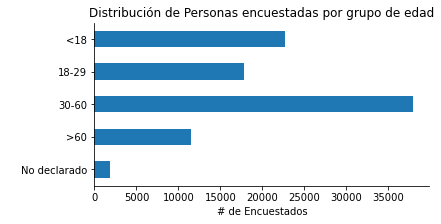

In [ ]:
order = ['<18', '18-29', '30-60','>60','No declarado']
ax = (personas_df.groupby(['age_cohort']).size().loc[reversed(order)]
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por grupo de edad")
sns.despine()

La mayor parte de los encuestados tiene entre 30 y 60 años de edad.

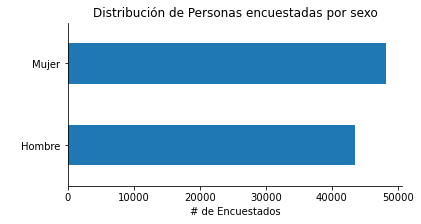

In [ ]:
ax = (personas_df.groupby(['SEXO']).size()
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo")
sns.despine()

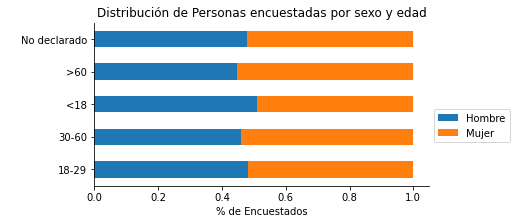

In [ ]:
ax = (personas_df.groupby(['age_cohort', 'SEXO']).size().unstack()
 .pipe(normalize_rows)
 .plot(kind='barh', stacked=True, figsize=(6, 3)))
ax.set_xlabel("% de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo y edad")
sns.despine()

plt.legend(loc=0, bbox_to_anchor=(1.0, 0.5))

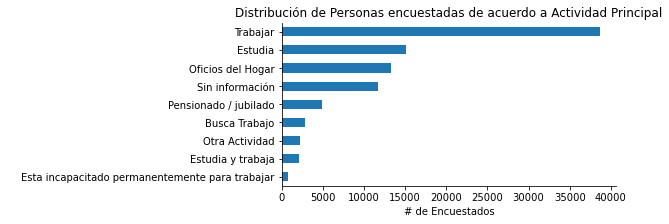

In [ ]:
ax = (personas_df.groupby(['ACTIVIDAD_PRINCIPAL']).size().sort_values()
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas de acuerdo a Actividad Principal")
sns.despine()

Vemos que la mayor parte de los encuestados son en su mayoria trabajadores, con edades entre 30 y 60 años, con una cantidad equilibrada de hombres y mujeres.

### Parte I: Indicadores de Cantidad de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de cantidades de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:

1. ¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?
2. ¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?
3. ¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?
4. ¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?

En esta sección, se detallarán los resultados para indicadores a nivel de viajes, separados por días hábiles y no hábiles de viaje, y por clasificador socioeconómico.

In [ ]:
agg_columns = ["CLASIFICACION_SISBEN","SEXO"]

In [ ]:
print('Cantidad de viajes mapeados: totales encuesta , total expandido')
viajes_habiles = viajes_personas[viajes_personas.DIA_HABIL=='Si']
print('Total Viajes Habiles: {}'.format(viajes_habiles.shape[0]), viajes_habiles['PONDERADOR_CALIBRADO_VIAJES'].sum())
viajes_nohabiles = viajes_personas[viajes_personas.DIA_NOHABIL=='Si']
print('Total Viajes No Habiles: {}'.format(viajes_nohabiles.shape[0]), viajes_nohabiles['PONDERADOR_CALIBRADO_VIAJES'].sum())

Cantidad de viajes mapeados: totales encuesta , total expandido
Total Viajes Habiles: 129465 17241048.149785925
Total Viajes No Habiles: 17720 15712253.835954381


Separamos los viajes hábiles y no hábiles de acuerdo a si son privados o públicos:

In [ ]:
viajes_publico_habiles = viajes_habiles[viajes_habiles.MEDIO_PREDOMINANTE.isin(publico_viaje)]
viajes_publico_nohabiles = viajes_nohabiles[viajes_nohabiles.MEDIO_PREDOMINANTE.isin(publico_viaje)]

viajes_privado_habiles = viajes_habiles[viajes_habiles.MEDIO_PREDOMINANTE.isin(privado_viaje)]
viajes_privado_nohabiles = viajes_nohabiles[viajes_nohabiles.MEDIO_PREDOMINANTE.isin(privado_viaje)]

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

In [ ]:
from pandasql import sqldf
def calculate_n_viajes_per_capita(df, df_str, agg_columns_str, agg_columns_lst, id_person, person_weight, trip_weight=None):
    q = "SELECT DISTINCT {}, {}, {} FROM {}".format(id_person, agg_columns_str, person_weight, df_str)
    persons = sqldf(q, globals())
    n_personas = persons.groupby(agg_columns_lst).sum()[[person_weight]].reset_index()
    n_personas[agg_columns_lst[0]] = n_personas[agg_columns_lst[0]].astype(str)
    n_viajes = df.groupby(agg_columns_lst).sum()[[trip_weight]].reset_index()
    n_viajes[agg_columns_lst[0]] = n_viajes[agg_columns_lst[0]].astype(str)
    merged = pd.merge(n_personas, n_viajes, on=agg_columns_lst, how='left')
    merged['viajes_per_capita'] = merged[trip_weight] / merged[person_weight]
    return merged

**texto en negrita**#### **¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?**

Los siguientes gráficos muestran los viajes per cápita en trasporte público durante días hábiles, por clasificador socioeconómico.

/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


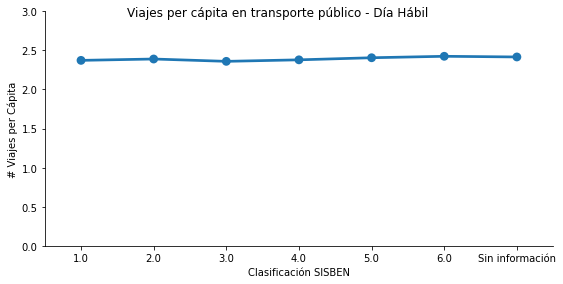

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
df = calculate_n_viajes_per_capita(viajes_publico_habiles, "viajes_publico_habiles", "CLASIFICACION_SISBEN", ["CLASIFICACION_SISBEN"], 'ID_PERSONA', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')


g = sns.catplot(x="CLASIFICACION_SISBEN", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Clasificación SISBEN')
g.set(ylim=(0,3))

#fig.tight_layout()


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


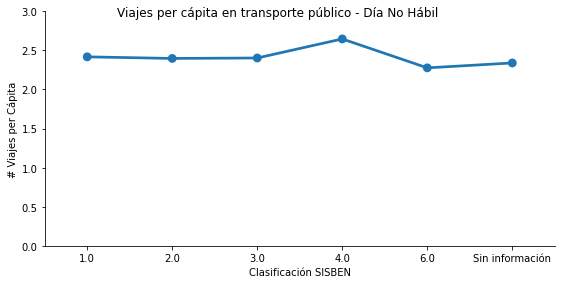

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
df = calculate_n_viajes_per_capita(viajes_publico_nohabiles, "viajes_publico_nohabiles", "CLASIFICACION_SISBEN", ["CLASIFICACION_SISBEN"], 'ID_PERSONA', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')


g = sns.catplot(x="CLASIFICACION_SISBEN", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Clasificación SISBEN')
g.set(ylim=(0,3))

#fig.tight_layout()

Para días hábiles, no se ve diferencia a través de la clasificación socioeconómica. En días no hábiles, se ve una tendencia similar, con un leve aumento en el 4to clasificador.



```
# E`sto tiene formato de código`
```

#### **¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?**

Los siguientes gráficos representan la tasa promedio de viajes diarios en el transporte privado durante días hábiles y no hábiles, por clasificador socioeconómico.

/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


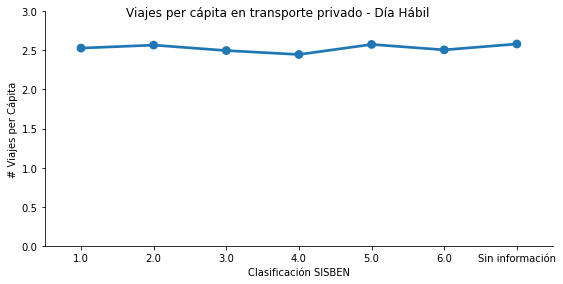

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
df = calculate_n_viajes_per_capita(viajes_privado_habiles, "viajes_privado_habiles", "CLASIFICACION_SISBEN", ["CLASIFICACION_SISBEN"], 'ID_PERSONA', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')

g = sns.catplot(x="CLASIFICACION_SISBEN", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Clasificación SISBEN')
g.set(ylim=(0,3))

#fig.tight_layout()

/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


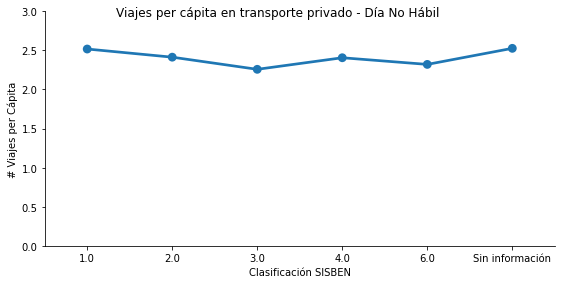

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
df = calculate_n_viajes_per_capita(viajes_privado_nohabiles, "viajes_privado_nohabiles", "CLASIFICACION_SISBEN", ["CLASIFICACION_SISBEN"], 'ID_PERSONA', 'PONDERADOR_CALIBRADO', 'PONDERADOR_CALIBRADO_VIAJES')

g = sns.catplot(x="CLASIFICACION_SISBEN", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Clasificación SISBEN')
g.set(ylim=(0,3))

#fig.tight_layout()

Durante días hábiles, la cantidad de viajes per cápita realizados en transporte privado se mantiene constante a través de los grupos, mientras que en días no hábiles los viajes tienden a disminuir con el aumento de nivel de la clasificación.

#### **¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?**

Los gráficos a continuación muestran la razón entre los viajes en transporte público y transporte privado durante días hábiles y no hábiles, por clasificador socioeconómico.

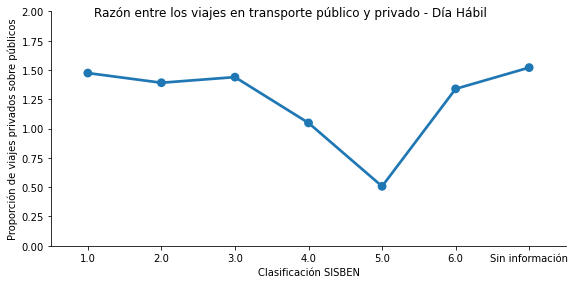

In [ ]:
viajes_privados = viajes_privado_habiles.groupby(["CLASIFICACION_SISBEN"]).agg(n_privados= ('PONDERADOR_CALIBRADO_VIAJES', 'sum')).reset_index()
viajes_publicos = viajes_publico_habiles.groupby(["CLASIFICACION_SISBEN"]).agg(n_publicos = ('PONDERADOR_CALIBRADO_VIAJES', 'sum')).reset_index()
n_viajes_modo = pd.merge(viajes_privados, viajes_publicos, on='CLASIFICACION_SISBEN')#.set_index('CLASIFICACION_SISBEN')
n_viajes_modo['privado_sobre_publico'] = n_viajes_modo['n_privados'] / n_viajes_modo['n_publicos']

g = sns.catplot(x="CLASIFICACION_SISBEN", y="privado_sobre_publico",
                capsize=.2, height=4, aspect=2,
                kind="point", data=n_viajes_modo)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Clasificación SISBEN')
g.set(ylim=(0,2))

#fig.tight_layout()

La razón entre viajes entre transporte público y privado se mantiene constante en los primeros 3 grupos, mientras que en los últimos 3 se ve una disminución, particularmente en el grupo 5.

#### **¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?**

Las siguientes tablas y gráficos representan la partición modal de los viajes realizados en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
df = viajes_habiles.groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df_norm= df.div(df.sum(axis=1), axis=0).fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if __name__ == '__main__':


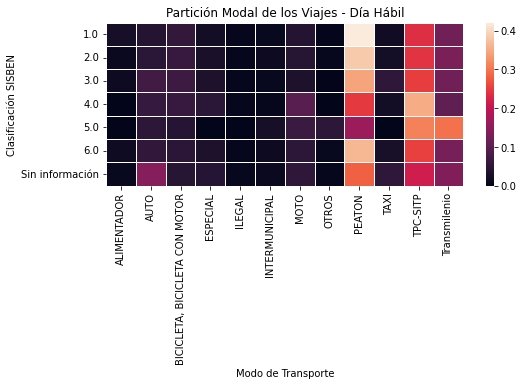

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

In [ ]:
df = viajes_nohabiles.groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df_norm= df.div(df.sum(axis=1), axis=0).fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if __name__ == '__main__':


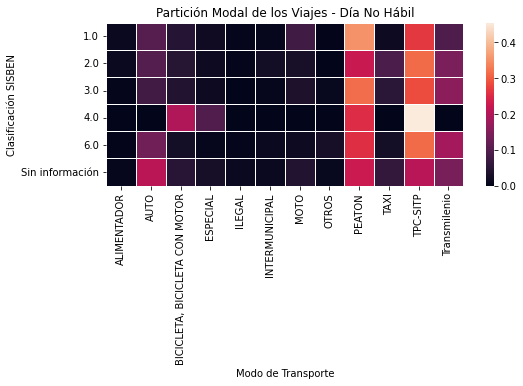

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

Tanto en días hábiles y no hábiles, los modos de transporte con una mayor distribución corresponden a Peatón y TPC-SITP.

A continuación, se representa la partición modal de los viajes por tipo de transporte en días hábiles y no hábiles, por quintiles de ingreso de acuerdo a la clasificación SISBEN.

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil')
df = viajes_habiles.groupby(["CLASIFICACION_SISBEN", 'publico_privado']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil


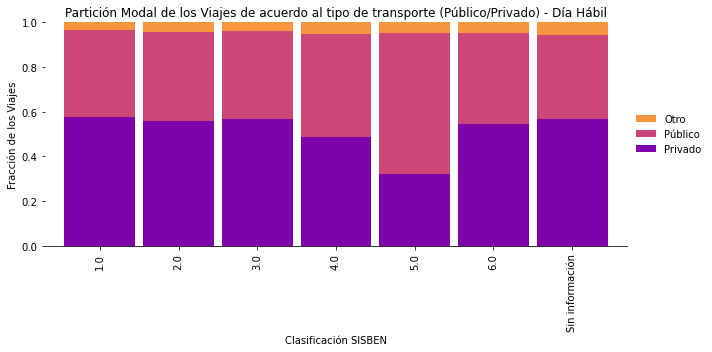

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(10,5))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte (Público/Privado) - Día Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Clasificación SISBEN")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte (Motorizado/No Motorizado) - Día Hábil')
df = viajes_habiles.groupby(["CLASIFICACION_SISBEN", 'motorizado']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes de acuerdo al tipo de transporte (Motorizado/No Motorizado) - Día Hábil


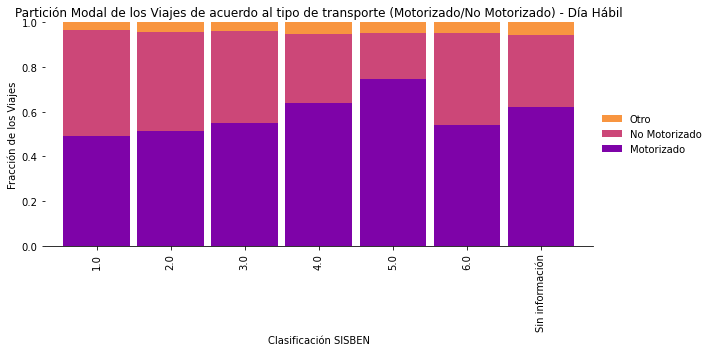

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(10, 5))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte (Motorizado/No Motorizado) - Día Hábil")
ax.set_ylim([0, 1])
ax.set_xlabel("Clasificación SISBEN")
ax.set_ylabel("Fracción de los Viajes")

fig.tight_layout()

Al ver la fracción de viajes para transporte privado y público, podemos ver que hay una razón similar entre los grupos, excepto el grupo 4 y 5, donde se ve una disminución de la fracción privada. En el caso del tipo de transporte motorizado o no motorizado, la fracción de viajes en transporte no motorizado aumenta al aumentar el nivel de la clasificación hasta el grupo 5.

### Parte II: Indicadores de Tiempo de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de tiempo de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:
1. ¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?
2. ¿Cuál es el tiempo promedio de viaje en hora punta de mañana?
3. ¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?
4. ¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?

En esta sección, se presentarán los indicadores de tiempo de viajes a nivel de viajes, durante días hábiles, y por clasificador socioeconómico.

In [ ]:
viajes_habiles['duracion_minutos'] = pd.to_timedelta(viajes_habiles['duracion'])/pd.Timedelta('60s')
viajes_nohabiles['duracion_minutos'] = pd.to_timedelta(viajes_nohabiles['duracion'])/pd.Timedelta('60s')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### **¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?**

A continuación, se representa el promedio y mediana en minutos de viaje por modo y tipo de transporte en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia Hábil')
df =viajes_habiles.groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
#df

Duración promedio (en minutos) de viaje por modo - Dia Hábil


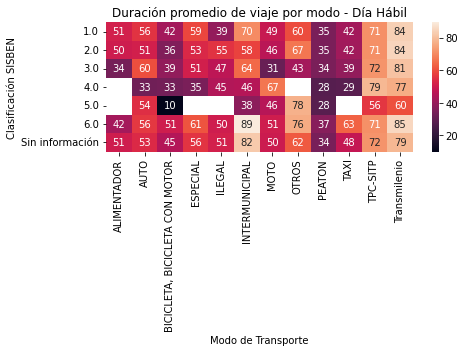

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()
#df

Duración mediana (en minutos) de viaje por modo - Dia Hábil


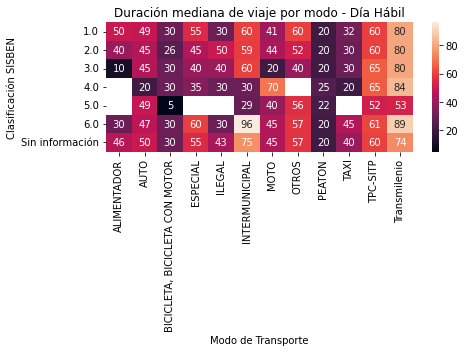

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

Al analizar los modos de transporte, podemos observar que Transmilenio es el modo con mayor duración de viajes, seguido de TPC-SITP. Los viajes con menor duración promedio corresponden a los realizados como Peatón.

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


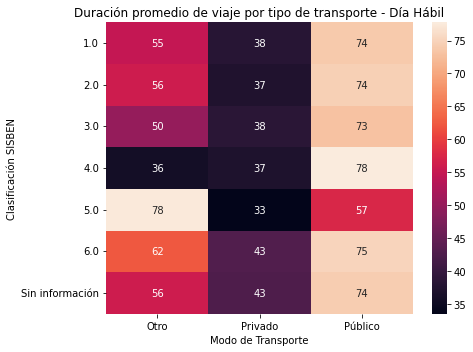

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["CLASIFICACION_SISBEN", 'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["CLASIFICACION_SISBEN",'publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil


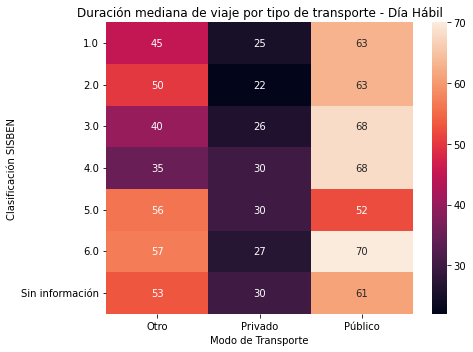

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por tipo de transporte - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

Al analizar por tipo de transporte, se observa que el transporte público presenta las mayores duraciones de viaje promedio, y el transporte público tiene menores tiempos de viaje en promedio.

Duración promedio (en minutos) de viaje por tipo de transporte (motorizado/no motorizado) - Dia Hábil


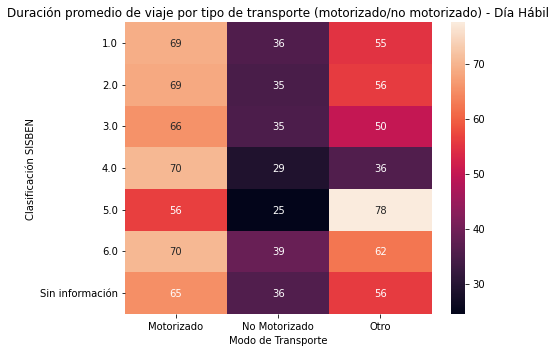

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte (motorizado/no motorizado) - Dia Hábil')
df = viajes_habiles.groupby(["CLASIFICACION_SISBEN", 'motorizado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por tipo de transporte (motorizado/no motorizado) - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

En cuanto al tipo de transporte (motorizado/no motorizado), podemos ver que los viajes en transporte motorizado tienen la menor duración promedio, mientras que el transporte no motorizado tiene viajes con mayor duración promedio.

#### **¿Cuál es el tiempo promedio de viaje en hora punta de mañana?**

Estos son los resultados para el promedio y mediana en minutos de viaje en hora punta de la mañana por modo de transporte, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if __name__ == '__main__':


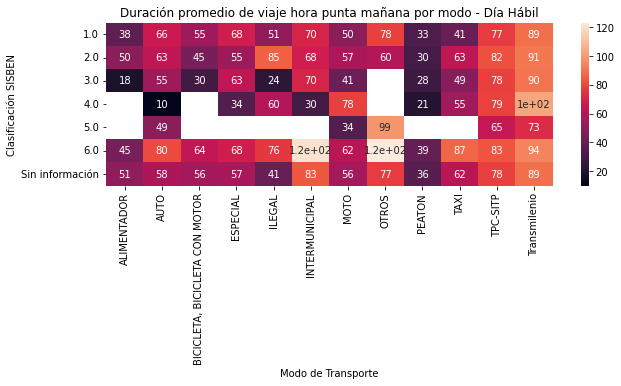

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if __name__ == '__main__':


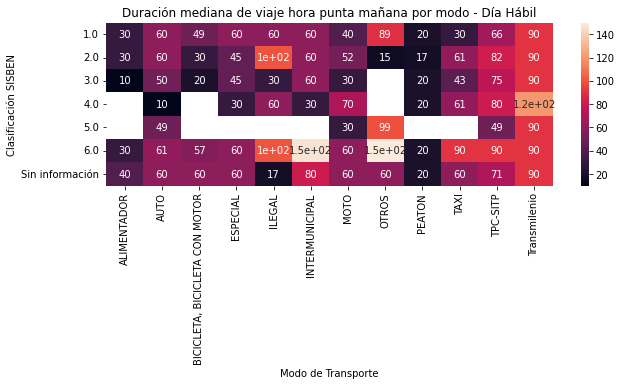

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

Independiente del tipo de día, los medios de transporte con tiempos de viaje en hora punta de mañana más altos corresponden a Intermunicipal, TCP-SITP y Transmilenio. Los viajes realizados como Peatón tienen las duraciones más cortas.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["CLASIFICACION_SISBEN",'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


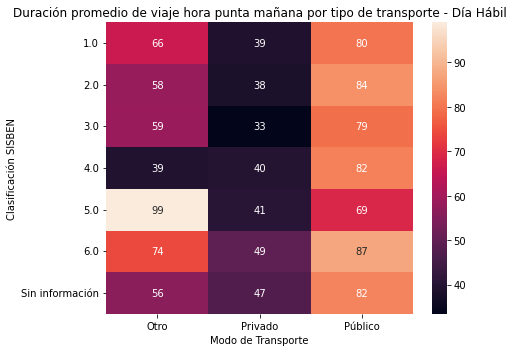

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje hora punta mañana por tipo de transporte - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["CLASIFICACION_SISBEN", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


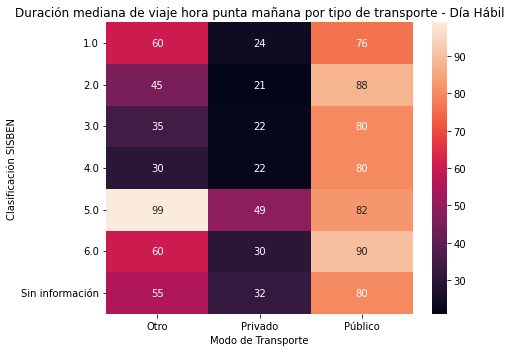

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje hora punta mañana por tipo de transporte - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

En ambos tipos de días, los viajes realizados en transporte público en hora punta de mañana presentan la mayor duración, en contraste con los realizados en transporte privado, que tienen duraciones más cortas.

#### **¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?**

A continuación, se presentan los resultados para duración promedio de viaje en hora punta de mañana en transporte público, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'][mask].groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


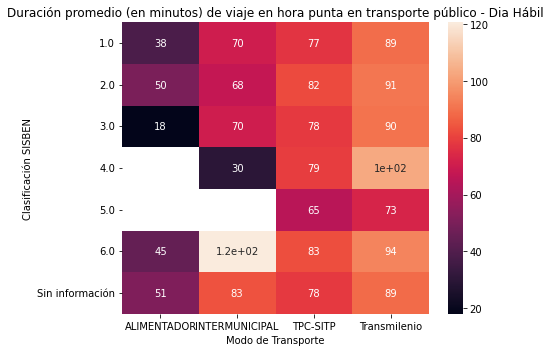

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'][mask].groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


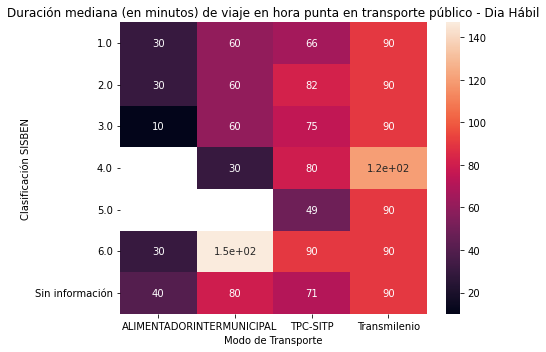

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

Los viajes realizados en transporte público en hora punta de mañana son más largos cuando se realizan en Transmilenio, mientras que los más cortos son los realizados en Alimentador para días hábiles y no hábiles.

#### **¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?**

A continuación, se presentan los resultados de tiempo promedio de viaje al trabajo en transporte público por modo en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.MOTIVOVIAJE=='Trabajar')
df = viajes_habiles[mask].groupby(["CLASIFICACION_SISBEN", "MEDIO_PREDOMINANTE"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


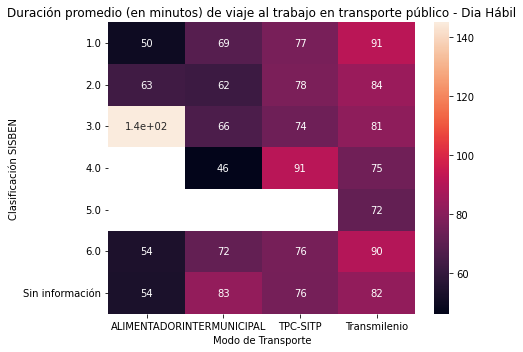

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.MOTIVOVIAJE=='Trabajar')
df = viajes_habiles[mask].groupby(["CLASIFICACION_SISBEN", 'MEDIO_PREDOMINANTE']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'PONDERADOR_CALIBRADO_VIAJES')).unstack()

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


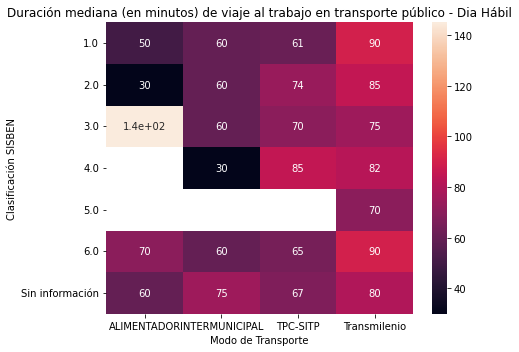

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Clasificación SISBEN")

fig.tight_layout()

Los tiempos de viaje al trabajo en transporte público son similares entre sí al comparar por modos, con Transmilenio registrando viajes levemente más largos que los otros modos, y destacan los viajes en Alimentador para el grupo 3 como los viajes más largos.

### Parte III: Indicadores de Distancia de Viajes


En esta sección, se presentarán los indicadores de distancia de viajes durante días hábiles.

#### **Distancia de viajes en auto (histograma de viajes por km)**

Distancia de viajes en auto - Día Hábil


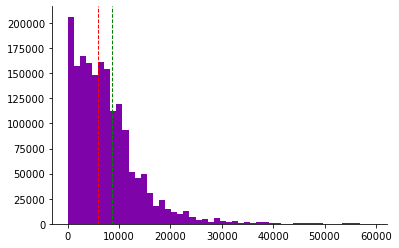

In [ ]:
from matplotlib.pyplot import hist
print('Distancia de viajes en auto - Día Hábil')
mask = (viajes_habiles.MEDIO_PREDOMINANTE == 'AUTO') & (viajes_habiles.distancia_manhattan<100000)
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('distancia_manhattan')
df.describe()
hist(df.distancia_manhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_habiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

Distancia de viajes en auto - Día No Hábil


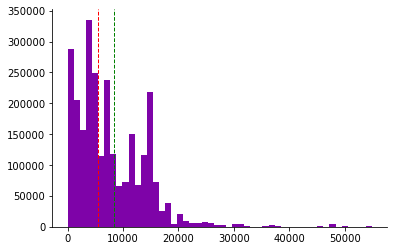

In [ ]:
print('Distancia de viajes en auto - Día No Hábil')
mask = (viajes_nohabiles.MEDIO_PREDOMINANTE == 'AUTO') & (viajes_nohabiles.distancia_manhattan<100000)
df = viajes_nohabiles[mask].groupby('distancia_manhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes en transporte público**

Distancia de viajes en transporte público - Día Hábil


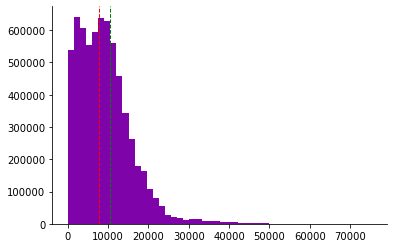

In [ ]:
print('Distancia de viajes en transporte público - Día Hábil')
mask = (viajes_habiles.publico_privado == 'Público') & (viajes_habiles.distancia_manhattan<100000)
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_habiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

Distancia de viajes en transporte público - Día No Hábil


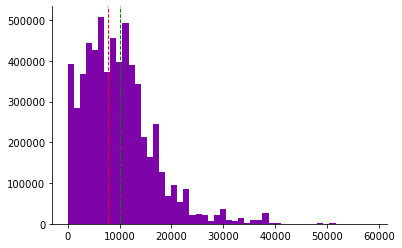

In [ ]:
print('Distancia de viajes en transporte público - Día No Hábil')
mask = (viajes_nohabiles.publico_privado == 'Público') & (viajes_nohabiles.distancia_manhattan<100000)
df = viajes_nohabiles[mask].groupby('distancia_manhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo estudio**

Distancia de viajes con motivo de estudio


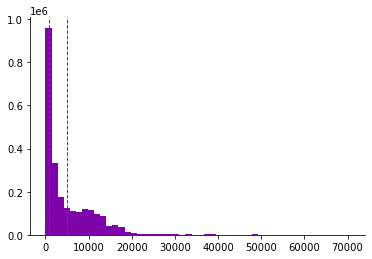

In [ ]:
print('Distancia de viajes con motivo de estudio')
mask = (viajes_personas.MOTIVOVIAJE == 'Estudiar') & (viajes_personas.distancia_manhattan<100000)
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_personas[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo trabajo**

Distancia de viajes con motivo de trabajo


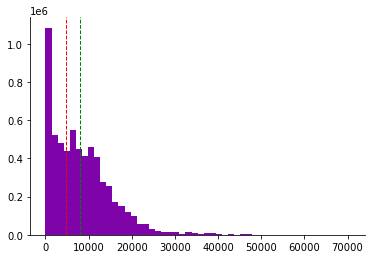

In [ ]:
print('Distancia de viajes con motivo de trabajo')
mask = (viajes_personas.MOTIVOVIAJE == 'Trabajar') & (viajes_personas.distancia_manhattan<100000)
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['PONDERADOR_CALIBRADO_VIAJES']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.PONDERADOR_CALIBRADO_VIAJES, bins=50)
plt.axvline(viajes_personas[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('ID_ENCUESTA').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Proporción de viajes intrazonales versus interzonales**

In [ ]:
print('% de viajes Inter e Intra zonales')
df = viajes_personas.groupby(['MOTIVOVIAJE','SEXO','Intra_Inter']).sum()['PONDERADOR_CALIBRADO_VIAJES'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra zonales


Intra_Inter                                               Inter     Intra
MOTIVOVIAJE                                    SEXO                      
Asuntos de Trabajo                             Hombre  0.942715  0.057285
                                               Mujer   0.913006  0.086994
Buscar / Dejar alguien bajo su cuidad          Hombre  0.828626  0.171374
                                               Mujer   0.741716  0.258284
Buscar / dejar a alguien que no esta bajo su c Hombre  0.955518  0.044482
                                               Mujer   0.820330  0.179670
Buscar trabajo                                 Hombre  0.937979  0.062021
                                               Mujer   0.888955  0.111045
Buscar/dejar dejar algo                        Hombre  0.725476  0.274524
                                               Mujer   0.857620  0.142380
Comer / Tomar algo                             Hombre  0.793124  0.206876
                                               Mujer   0.881545  0.118455
Compras                                        Hombre  0.819916  0.180084
                                               Mujer   0.757145  0.242855
Estudiar                                       Hombre  0.841162  0.158838
                                               Mujer   0.829406  0.170594
Ir a ver a alguien                             Hombre  0.927334  0.072666
                                               Mujer   0.878047  0.121953
Otra cosa                                      Hombre  0.871944  0.128056
                                               Mujer   0.850266  0.149734
Recibir atencion en salud                      Hombre  0.964439  0.035561
                                               Mujer   0.943092  0.056908
Recreacion                                     Hombre  0.833194  0.166806
                                               Mujer   0.862576  0.137424
Trabajar                                       Hombre  0.917084  0.082916
                                               Mujer   0.923609  0.076391
Tramites                                       Hombre  0.925735  0.074265
                                               Mujer   0.896723  0.103277
Volver a casa                                  Hombre  0.889999  0.110001
                                               Mujer   0.867574  0.132426

#### **¿Dónde se concentran las personas que utilizan cada modo de transporte en la ciudad para distintos propósitos?**

In [ ]:
from aves.features.geo import clip_area_geodataframe
bbox = [-74.4189,4.3612,-73.8201,5.0477]

zonas_en_caja = clip_area_geodataframe(city_shp.to_crs('epsg:4686'), bbox)
#zonas_en_caja.plot()

/usr/local/lib/python3.7/site-packages/aves/features/geo.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ).pipe(lambda x: x[x.geometry.area > 0])


In [ ]:
bounds = zonas_en_caja.to_crs('EPSG:4686').total_bounds

In [ ]:
import contextily as cx

scl_img, scl_ext = cx.bounds2raster(bounds[0], bounds[1], bounds[2], bounds[3], 
    "bogota_toner_12.tif",
    ll=True,
    source=cx.providers.Stamen.TonerBackground,
    zoom=12,
)

In [ ]:
from aves.features.geo import to_point_geodataframe

In [ ]:
origenes_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_ORIGEN' , 'LATITUD_ORIGEN', crs='epsg:4686')
destinos_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_DESTINO', 'LATITUD_DESTINO', crs='epsg:4686')

In [ ]:
city_shp = city_shp.to_crs(origenes_viajes.crs)

In [ ]:
filter_out = [819,820,821,812,814,811,801,800,810,809,823,824,818,822,796]

In [ ]:
city_shp_filt = city_shp[~city_shp.Zona_Num_N.isin(filter_out)].to_crs(origenes_viajes.crs)
city_shp_filt.shape

(933, 6)

In [ ]:
from aves.features.geo import clip_point_geodataframe

origenes_viajes = origenes_viajes[(origenes_viajes['ID_ENCUESTA'].isin(destinos_viajes['ID_ENCUESTA']))]
origenes_viajes = clip_point_geodataframe(origenes_viajes, zonas_en_caja.total_bounds)
destinos_viajes = destinos_viajes[(destinos_viajes['ID_ENCUESTA'].isin(origenes_viajes['ID_ENCUESTA']))]
destinos_viajes = clip_point_geodataframe(destinos_viajes, zonas_en_caja.total_bounds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


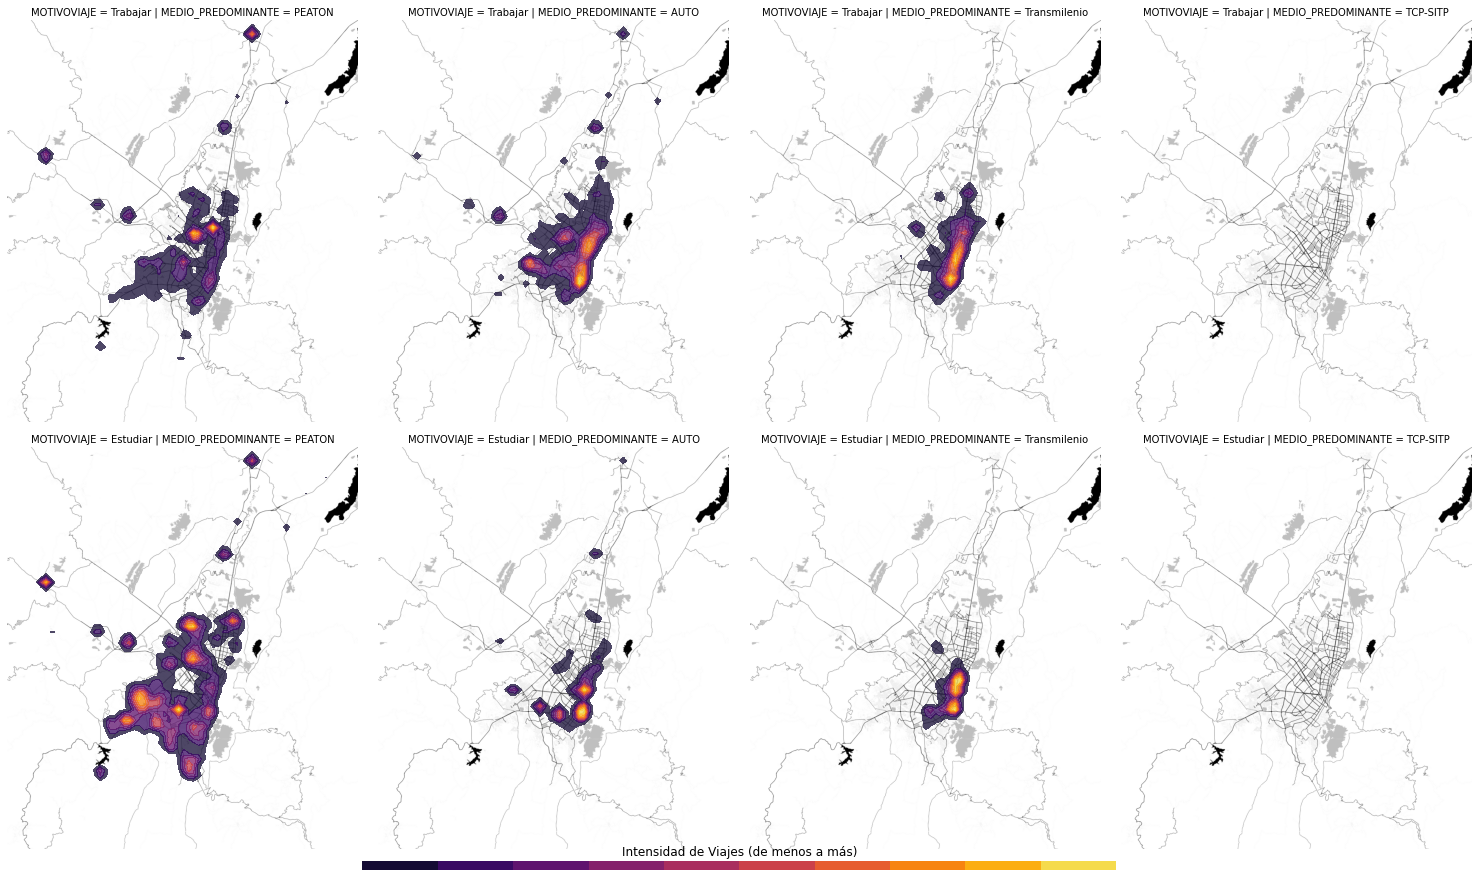

In [ ]:
from aves.visualization.figures import GeoFacetGrid

from aves.visualization.maps import heat_map

grid = GeoFacetGrid(
    origenes_viajes,
    context=zonas_en_caja,
    row="MOTIVOVIAJE",
    col="MEDIO_PREDOMINANTE",
    row_order=["Trabajar", "Estudiar"],
    col_order=["PEATON", "AUTO", "Transmilenio", "TCP-SITP"],
    height=6,
    hue="MEDIO_PREDOMINANTE"
)
grid.add_basemap("bogota_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="PONDERADOR_CALIBRADO_VIAJES",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)

grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
#grid.set_title("Viajes a trabajar y a estudiar de acuerdo al modo de transporte")
grid.fig.tight_layout()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


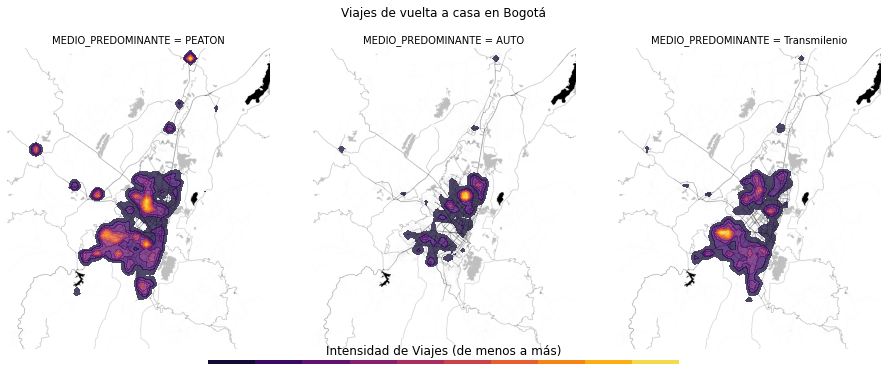

In [ ]:
grid = GeoFacetGrid(
    destinos_viajes[destinos_viajes.MOTIVOVIAJE=='Volver a casa'],
    context=zonas_en_caja,
    #row="MOTIVOVIAJE",
    col="MEDIO_PREDOMINANTE",
    col_wrap=3,
    row_order=["Volver a casa"],
    col_order=["PEATON", "AUTO", "Transmilenio"],
    height=5,
    hue="MEDIO_PREDOMINANTE"
)
grid.add_basemap("bogota_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1, alpha=0.5)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="PONDERADOR_CALIBRADO_VIAJES",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)
grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
grid.set_title("Viajes de vuelta a casa en Bogotá")
grid.fig.tight_layout()

¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [ ]:
viajes_trabajo = origenes_viajes[(origenes_viajes.MOTIVOVIAJE == 'Trabajar') &
                                (pd.notnull(origenes_viajes.PONDERADOR_CALIBRADO_VIAJES)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['ID_ENCUESTA', 'NUMERO_PERSONA'], keep='first')
                                
print(len(viajes_trabajo), viajes_trabajo.PONDERADOR_CALIBRADO_VIAJES.sum())

20700 5687776.383537747


In [ ]:
viajes_trabajo['distancia_manhattan'].mean(), weighted_mean(viajes_trabajo, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES')

(11970.36673793232, 9070.8702809478)

In [ ]:
distancia_zonas_mean = (viajes_trabajo
                   .groupby(['ZAT_ORIGEN'])
                   .apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES'))
                   .rename('media_distancia_al_trabajo')
)

In [ ]:
distancia_zonas_median = (viajes_trabajo
                   .groupby(['ZAT_ORIGEN'])
                   .apply(lambda x: weighted_median(x, 'distancia_manhattan', 'PONDERADOR_CALIBRADO_VIAJES'))
                   .rename('mediana_distancia_al_trabajo')
)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


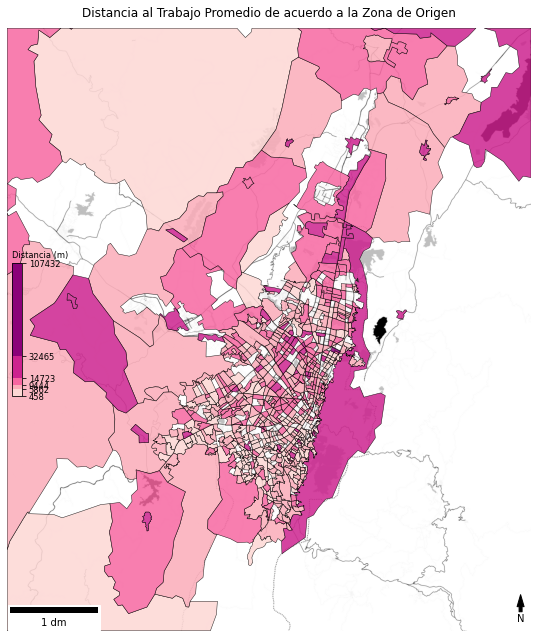

In [ ]:
from aves.visualization.maps import choropleth_map
grid = GeoFacetGrid(zonas_en_caja.join(distancia_zonas_mean, how="left"), height=9)
grid.add_basemap("bogota_toner_12.tif")
grid.add_layer(
    choropleth_map,
    "media_distancia_al_trabajo",
    k=5,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    palette="RdPu",
    alpha=0.85,
    cbar_args=dict(
        label="Distancia (m)",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ),
)
grid.add_map_elements()
grid.set_title("Distancia al Trabajo Promedio de acuerdo a la Zona de Origen")
grid.tight_layout()

In [ ]:
city_shp_filt = city_shp_filt[~city_shp_filt.geometry.isnull()]

In [ ]:
matriz_zonas = (viajes_trabajo[(viajes_trabajo['ZAT_ORIGEN'] != viajes_trabajo['ZAT_DESTINO'])
                            & (viajes_trabajo.DIA_HABIL=='Si')
                             & (viajes_trabajo['ZAT_ORIGEN'].isin(city_shp_filt.Zona_Num_N))
                             & (viajes_trabajo['ZAT_DESTINO'].isin(city_shp_filt.Zona_Num_N))]
                    .groupby(['ZAT_ORIGEN', 'ZAT_DESTINO'])
                    .agg(n_viajes=('PONDERADOR_CALIBRADO_VIAJES', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)

In [ ]:
matriz_zonas = matriz_zonas[matriz_zonas['cumsum_viajes'] <= 0.45]


In [ ]:
merged_zones = city_shp_filt.dissolve('Zona_Num_N').drop('id', axis=1)

In [ ]:
from aves.models.network import Network
from aves.visualization.networks import NodeLink

zone_od_network = Network.from_edgelist(
    matriz_zonas, source="ZAT_ORIGEN", target="ZAT_DESTINO", weight="n_viajes"
)

In [ ]:
zone_nodelink = NodeLink(zone_od_network)

In [ ]:
zone_nodelink.layout_nodes(method="geographical", geodataframe=merged_zones)

/usr/local/lib/python3.7/site-packages/aves/models/network/layouts.py:165: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  node_positions = positions_to_array(self.geodf.geometry.centroid)


In [ ]:
zone_nodelink.set_node_drawing("plain", weights=zone_od_network.node_degree("in"))
zone_nodelink.set_edge_drawing(method="origin-destination")

In [ ]:
zone_nodelink.bundle_edges(
    method="force-directed", K=10, S=0.01, I=10, compatibility_threshold=0.45, C=6
)

In [ ]:
def plot_network(ax, geo_data, *args, **kwargs):
    zone_nodelink.plot(ax, *args, **kwargs)

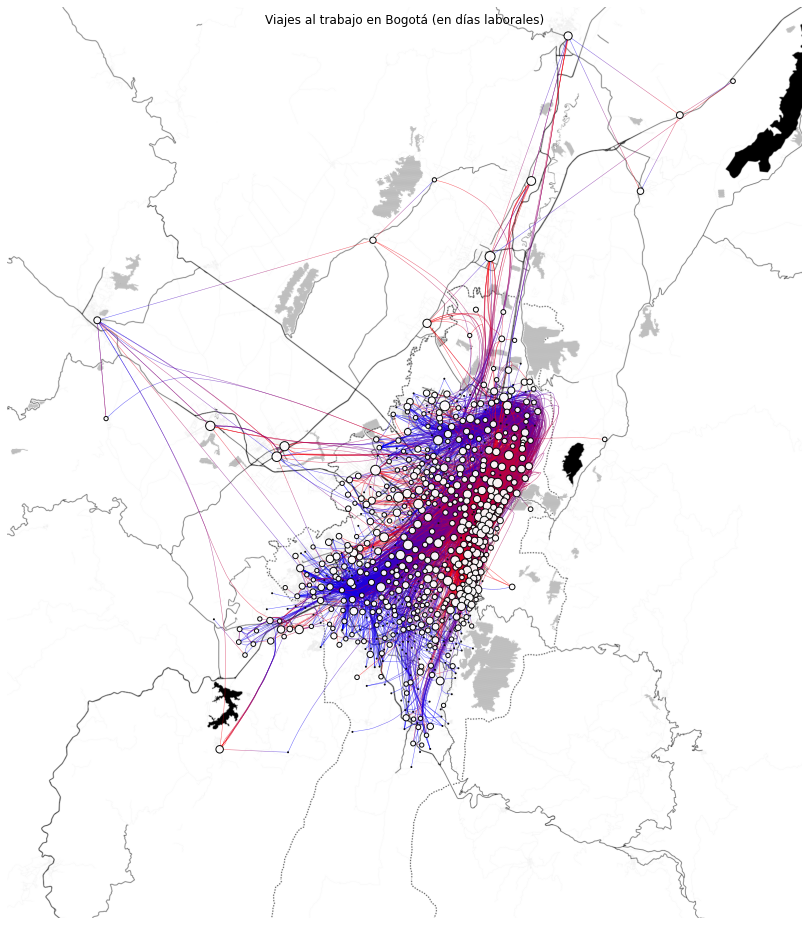

In [ ]:
grid = GeoFacetGrid(zonas_en_caja, height=13)
grid.add_basemap("bogota_toner_12.tif")
#grid.add_layer(city_shp_filt,facecolor='white', edgecolor='grey', alpha=0.25)
grid.add_layer(
    plot_network,
    nodes=dict(color="white", edgecolor="black", node_size=100, alpha=0.95),
    edges=dict(linewidth=0.5, alpha=0.6),
)
grid.set_title("Viajes al trabajo en Bogotá (en días laborales)")

In [ ]:
1+1

2